In [18]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from tensorflow.keras.utils import set_random_seed

random_seed = 2024
set_random_seed(random_seed)

In [ ]:
import requests
import zipfile

# Step 1: Download the file

# The URL of the file you want to download
url = "https://www.kaggle.com/datasets/alxmamaev/flowers-recognition/download?datasetVersionNumber=2"

# Send a GET request to the URL
response = requests.get(url, stream=True)

# Write the content of the response to a file
with open("archive.zip", "wb") as f:
    for chunk in response.iter_content(chunk_size=8192):
        f.write(chunk)

print("Downloaded archive.zip!")

# Step 2: Unzip the file

with zipfile.ZipFile("archive.zip", 'r') as zip_ref:
    zip_ref.extractall()

print("Unzipped the file")

### **What is the total number of images in the dataset, and how are they distributed across the five flower types?**
There are 4317 images in the dataset. The distribution across the five flower types is {'dandelion': 1052, 'rose': 784, 'tulip': 984, 'daisy': 764, 'sunflower': 733}

In [19]:
# find the total number of images in flowers folder
import os

data_path = 'flowers'
label_dict = dict()
total_images = 0

for folder in os.listdir(data_path):
    label_dict[folder] = len(os.listdir(os.path.join(data_path, folder)))
    total_images += len(os.listdir(os.path.join(data_path, folder)))

print("Total number of images in dataset: ", total_images)

Total number of images in dataset:  4317


Number of images in each class:  {'dandelion': 1052, 'rose': 784, 'tulip': 984, 'daisy': 764, 'sunflower': 733}


<BarContainer object of 5 artists>

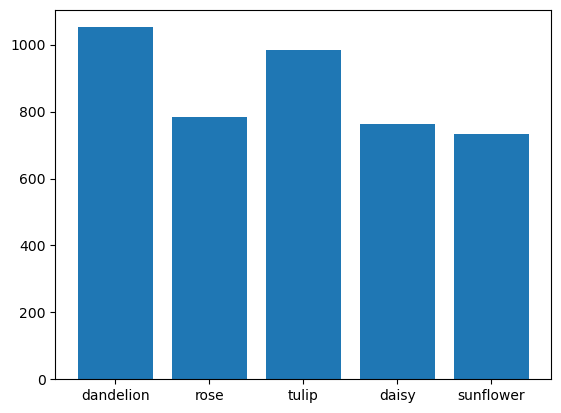

In [20]:
import matplotlib.pyplot as plt

print("Number of images in each class: ", label_dict)

plt.bar(label_dict.keys(), label_dict.values())

### **Do we need to implement techniques to balance the distribution of images across various flower types, such as oversampling or undersampling?**
The distribution of images across various flower types is somewhat imbalanced. While the imbalance isn't extreme, it's still significant enough to potentially affect the performance. Therefore, I would do oversampling though data augmentation.

### **What are the dimensions (height and width) of the images in the dataset, and is there any variation among different flower types?**
Dimensions of images in each class: 
- dandelion: {(320, 239), (320, 248), (500, 334), ..., (240, 176), (174, 240), (240, 240)}

- rose: {(500, 325), (320, 248), (500, 334), ..., (240, 167), (500, 243), (240, 240)}

- tulip: {(320, 239), (500, 316), (500, 261), ..., (320, 221), (174, 240), (240, 240)}

- daisy: {(500, 316), (320, 239), (320, 248), ..., (320, 221), (320, 230), (240, 240)}

- sunflower: {(500, 316), (320, 239), (500, 325), ..., (320, 285), (174, 240), (240, 240)}
        
The dimensions are shown above (details dimensions are shown below). There are a lot of variation among different flower types.

In [21]:
from tensorflow.keras.preprocessing.image import load_img

def check_image_dimensions(dataset_path):
    dimensions = {}

    for flower_type in os.listdir(dataset_path):
        flower_dir = os.path.join(dataset_path, flower_type)
        if os.path.isdir(flower_dir):
            for image_file in os.listdir(flower_dir):
                image_path = os.path.join(flower_dir, image_file)
                image = load_img(image_path)
                width, height = image.size
                dimensions.setdefault(flower_type, set()).add((width, height))

    return dimensions

image_dimensions = check_image_dimensions(data_path)

print("Dimensions of images in each class: ")
for flower_type, dims in image_dimensions.items():
    print(f"{flower_type}: {dims}")

Dimensions of images in each class: 
dandelion: {(320, 239), (320, 248), (500, 334), (320, 257), (500, 398), (187, 240), (240, 160), (320, 214), (202, 240), (240, 224), (320, 278), (320, 223), (240, 178), (500, 309), (240, 123), (320, 232), (500, 254), (320, 241), (240, 196), (500, 327), (160, 240), (500, 336), (500, 400), (240, 98), (240, 217), (320, 216), (240, 226), (320, 280), (240, 171), (320, 225), (217, 240), (320, 289), (240, 180), (320, 234), (500, 375), (240, 189), (500, 320), (320, 243), (500, 265), (500, 329), (179, 240), (240, 155), (234, 240), (500, 286), (320, 273), (320, 218), (500, 414), (240, 228), (320, 282), (240, 173), (500, 304), (500, 423), (500, 359), (320, 227), (500, 295), (320, 236), (500, 313), (500, 322), (196, 240), (240, 148), (240, 212), (156, 240), (320, 266), (320, 211), (240, 221), (320, 275), (240, 166), (320, 220), (240, 175), (320, 229), (240, 120), (240, 239), (500, 425), (500, 315), (320, 238), (134, 240), (162, 240), (239, 240), (320, 259), (240

### **What preprocessing techniques should be applied, such as resizing, normalization or standardization and why?**
I would do oversampling the dataset by data augmentation for the imbalance class distribution (target samples size 1052), resizing each images to the same dimensions (224x224), and normalize the pixel values to [0, 1] (we will normalize when model fit)

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, save_img

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)

def oversample_and_resize(dataset_path, target_samples):
    for flower_type in os.listdir(dataset_path):
        flower_dir = os.path.join(dataset_path, flower_type)
        
        if os.path.isdir(flower_dir):
            image_files = os.listdir(flower_dir)
            num_images = len(image_files)

            # Resize all existing images to 224x224
            for image_file in image_files:
                image_path = os.path.join(flower_dir, image_file)
                img = load_img(image_path, target_size=(224, 224))
                save_img(image_path, img)

            if num_images < target_samples:
                augmentations_required = target_samples - num_images
                print(f"Generating {augmentations_required} augmented images for {flower_type}...")

                generator = datagen.flow_from_directory(
                    dataset_path,
                    target_size=(224, 224),
                    batch_size=1,
                    classes=[flower_type],
                    save_to_dir=flower_dir,
                    save_prefix='aug',
                    save_format='jpg')
                
                for i in range(augmentations_required):
                    next(generator)

target_samples = 1052
oversample_and_resize(data_path, target_samples)

Generating 268 augmented images for rose...
Found 784 images belonging to 1 classes.
Generating 68 augmented images for tulip...
Found 984 images belonging to 1 classes.
Generating 288 augmented images for daisy...
Found 764 images belonging to 1 classes.
Generating 319 augmented images for sunflower...
Found 733 images belonging to 1 classes.


### **How would you split the dataset into training, validation and testing sets, and in what ratios?**
I would split training, validation and testing sets in ratio 0.8 : 0.1 : 0.1

In [23]:
print("Splitting dataset into train, validation and test sets with ratio (0.8:0.1:0.1)")

import splitfolders

splitfolders.ratio(data_path, output="dataset", seed=2023, ratio=(.8, .1, .1), group_prefix=None)

Splitting dataset into train, validation and test sets with ratio (0.8:0.1:0.1)


## **Implement the VGG16 CNN architecture. Use an input image size of $224 \times 224 \times 3$**
<img src='CNN.png' alt='given CNN'>

In [24]:
#Step 2 implementation 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout

model = Sequential()

model.add(Conv2D(64, (3, 3), activation='selu', padding='same', kernel_initializer='he_normal', input_shape=(224, 224, 3)))
model.add(Conv2D(64, (3, 3), activation='selu', padding='same', kernel_initializer='he_normal'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='selu', padding='same', kernel_initializer='he_normal'))
model.add(Conv2D(128, (3, 3), activation='selu', padding='same', kernel_initializer='he_normal'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(256, (3, 3), activation='selu', padding='same', kernel_initializer='he_normal'))
model.add(Conv2D(256, (3, 3), activation='selu', padding='same', kernel_initializer='he_normal'))
model.add(Conv2D(256, (3, 3), activation='selu', padding='same', kernel_initializer='he_normal'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(512, (3, 3), activation='selu', padding='same', kernel_initializer='he_normal'))
model.add(Conv2D(512, (3, 3), activation='selu', padding='same', kernel_initializer='he_normal'))
model.add(Conv2D(512, (3, 3), activation='selu', padding='same', kernel_initializer='he_normal'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(512, (3, 3), activation='selu', padding='same', kernel_initializer='he_normal'))
model.add(Conv2D(512, (3, 3), activation='selu', padding='same', kernel_initializer='he_normal'))
model.add(Conv2D(512, (3, 3), activation='selu', padding='same', kernel_initializer='he_normal'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Flatten())
model.add(Dense(4096, activation='selu', kernel_initializer='he_normal'))
model.add(Dense(4096, activation='selu', kernel_initializer='he_normal'))
model.add(Dense(5, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 conv2d_27 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 112, 112, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 conv2d_29 (Conv2D)          (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 56, 56, 128)      0         
 g2D)                                                 

### **What is your approach for selecting the appropriate hyperparameters for the model training, such as the learning rate, number of epochs, batch size, and optimizer?**

In general, we can select our appropriate hyperparameters through the performance of validation set. I would select my hyperparameters by considering following:

Learning Rate:
- I would start with a standard learning rate of 0.0001.

- Also use adaptive learning rate optimizers like Adam, which adjust the learning rate during training.

Number of Epochs:
- I would begin with a moderate number, such as 20-30 epochs, and monitor the validation loss and accuracy.

- Use early stopping with patience. This means if the validation loss does not improve for a certain number of epochs (patience parameter), training will be halted. This prevents overfitting and unnecessary training time.

Batch Size:
- The choice of batch size often depends on memory constraints. For architectures like VGG, typical batch sizes range from 16 to 128.

- I would start with a smaller batch size e.g. 32, which can provide a regularizing effect and lower generalization error.

Optimizer:
- I would start with Adam optimizer as it combines the best properties of the Adagrad and RMSprop algorithms. It adjusts the learning rate during training, which makes it efficient and requires less hyperparameter tuning.

- However, for deeper networks, SGD with momentum can sometimes outperform Adam. I might want to start with Adam for initial epochs and then switch to SGD for finer tuning if I want to push higher performance.

Activation Function:
- I would use Scaled Exponential Linear Units (SELU) as activation function, since the given CNN architecture is quite deep without any batch normalization or other structure to deal with vanishing gradient problem. otherwise, the deep network cannot be trained.

Weight Initialization: 
- I would use He initialization (he_normal in Keras) for SELU activated units. It can help the vanishing gradient problem mentioned above. 

- Proper weight initialization can speed up the training process.

### **What methods do you use for monitoring the training progress and performance of the model and why?**

I would use Loss and Accuracy Curves:

- By plotting training and validation loss and accuracy over epochs, one can visually inspect how the model is learning.

- A divergence between training and validation metrics might indicate overfitting.

- If both training and validation loss are high, the model might be underfitting.

I would use Early Stopping:

- Monitor validation loss and stop training once that it stops improving for a certain number of epochs (patience).

- This helps in preventing overfitting and reduces computational costs.

### **What metrics would you prefer to measure the performance, such as accuracy, precision, recall, F1 score, or ROC-AUC and why?**

I have equalized the number of samples in each class using oversampling through data augmentation, the dataset is now balanced.

Accuracy:
- With a balanced dataset, accuracy becomes a more reliable metric. It will give a clear picture of how well the model is performing across all classes since no class is now underrepresented. If the model achieves a high accuracy, it means it's performing well across all flower types.

Precision, Recall, and F1 Score:
- Even with a balanced dataset, these metrics are crucial to understand the model's behavior for each class. Precision will inform us how many of the predicted images for each flower type are actually correct, while recall will let us know how many of the actual images of each flower type the model correctly identified. The F1 score harmonizes precision and recall.

- For instance, if 'sunflower' images are often misclassified as 'daisy', even in a balanced dataset, we will see a drop in precision for 'daisy' and a drop in recall for 'sunflower'.

In [25]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import time

train_dir = 'dataset/train/'
val_dir = 'dataset/val/'

BATCH_SIZE = 32
EPOCHS = 25

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

Found 7349 images belonging to 5 classes.
Found 825 images belonging to 5 classes.


In [26]:
checkpoint_filepath = 'best_model_baseline.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

start_time = time.time()

history_1 = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    callbacks=[model_checkpoint_callback])

end_time = time.time()
print(f"Total training time of baseline model: {end_time - start_time} seconds")

model.save('model_baseline.h5')

Epoch 1/25
229/229 [==============================] - 28s 122ms/step - loss: 8.9157 - accuracy: 0.3829 - val_loss: 1.5341 - val_accuracy: 0.5650
Epoch 2/25
229/229 [==============================] - 28s 124ms/step - loss: 1.4100 - accuracy: 0.5430 - val_loss: 1.2530 - val_accuracy: 0.6350
Epoch 3/25
229/229 [==============================] - 27s 119ms/step - loss: 1.2867 - accuracy: 0.5871 - val_loss: 1.1445 - val_accuracy: 0.6200
Epoch 4/25
229/229 [==============================] - 29s 124ms/step - loss: 1.1796 - accuracy: 0.6151 - val_loss: 1.0519 - val_accuracy: 0.6413
Epoch 5/25
229/229 [==============================] - 29s 124ms/step - loss: 1.0296 - accuracy: 0.6499 - val_loss: 0.8271 - val_accuracy: 0.7100
Epoch 6/25
229/229 [==============================] - 27s 120ms/step - loss: 1.0612 - accuracy: 0.6583 - val_loss: 0.9029 - val_accuracy: 0.7075
Epoch 7/25
229/229 [==============================] - 27s 119ms/step - loss: 0.9591 - accuracy: 0.6863 - val_loss: 1.0101 - val_ac

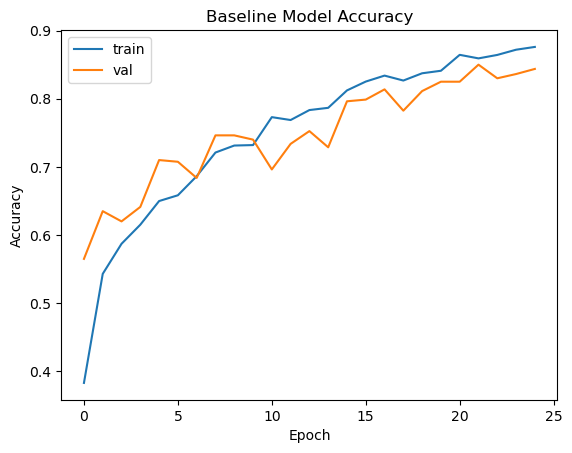

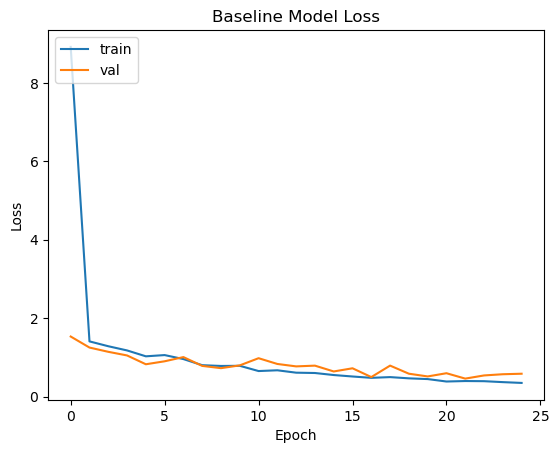

In [27]:
# plot the training and validation accuracy and loss at each epoch
import matplotlib.pyplot as plt

plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Baseline Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('Baseline Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### **What is the final accuracy of the model on the validation set, and how does it compare to the training accuracy?**
The final accuracy of the model on validation set is around 0.83, whereas the training accruacy is around 0.88.

### **What is the confusion matrix for the model on the validation set, and which flower types are the most difficult to classify?**

Found 825 images belonging to 5 classes.
26/26 [==============================] - 1s 29ms/step
Accuracy: 84.97%
Precision: 0.84
Recall: 0.83
F1 Score: 0.83


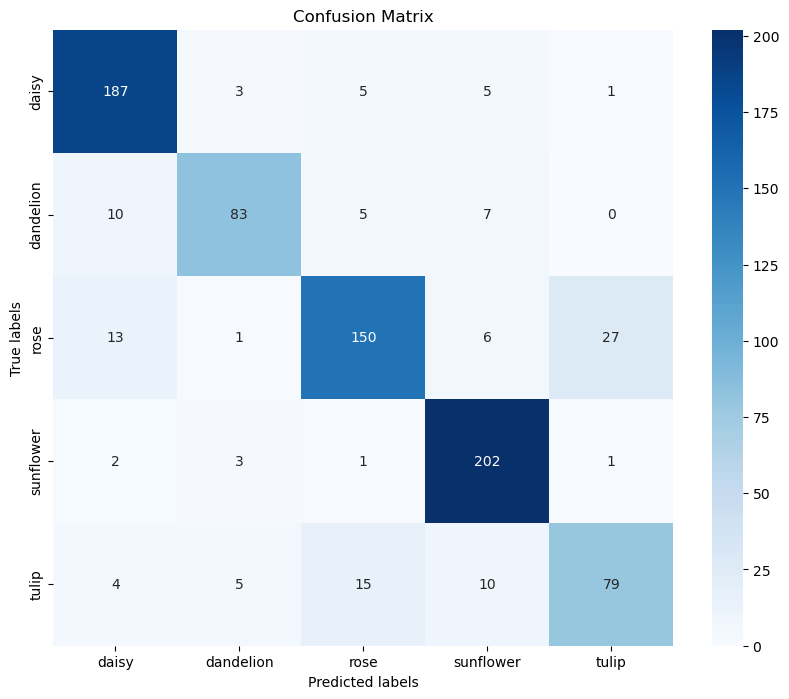

According to the confusion matrix, tulip is the most difficult flower types to classify.


In [28]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

model = tf.keras.models.load_model('best_model_baseline.h5')

val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False)

predictions = model.predict(val_generator)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = val_generator.classes

accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes, average='macro')
recall = recall_score(true_classes, predicted_classes, average='macro')
f1 = f1_score(true_classes, predicted_classes, average='macro')

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

conf_matrix = confusion_matrix(true_classes, predicted_classes)

class_labels = list(val_generator.class_indices.keys())

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

print("According to the confusion matrix, tulip is the most difficult flower types to classify.")

### **How does the model perform on individual flower types, and are there any particular images that the model struggles to classify?**

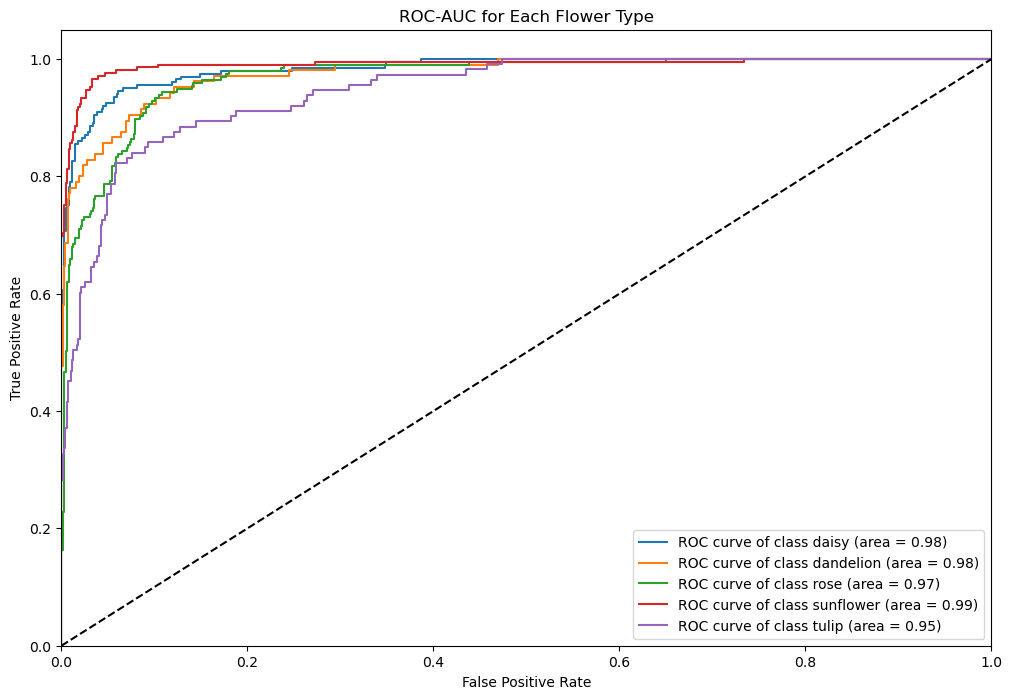

In [29]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

y_true_one_hot = label_binarize(val_generator.classes, classes=[0, 1, 2, 3, 4]) 
n_classes = y_true_one_hot.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_one_hot[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(12, 8))
for i, class_label in enumerate(val_generator.class_indices.keys()):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {class_label} (area = {roc_auc[i]:.2f})')
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC for Each Flower Type')
plt.legend(loc="lower right")
plt.show()

These are the images that the model struggles to classify: 


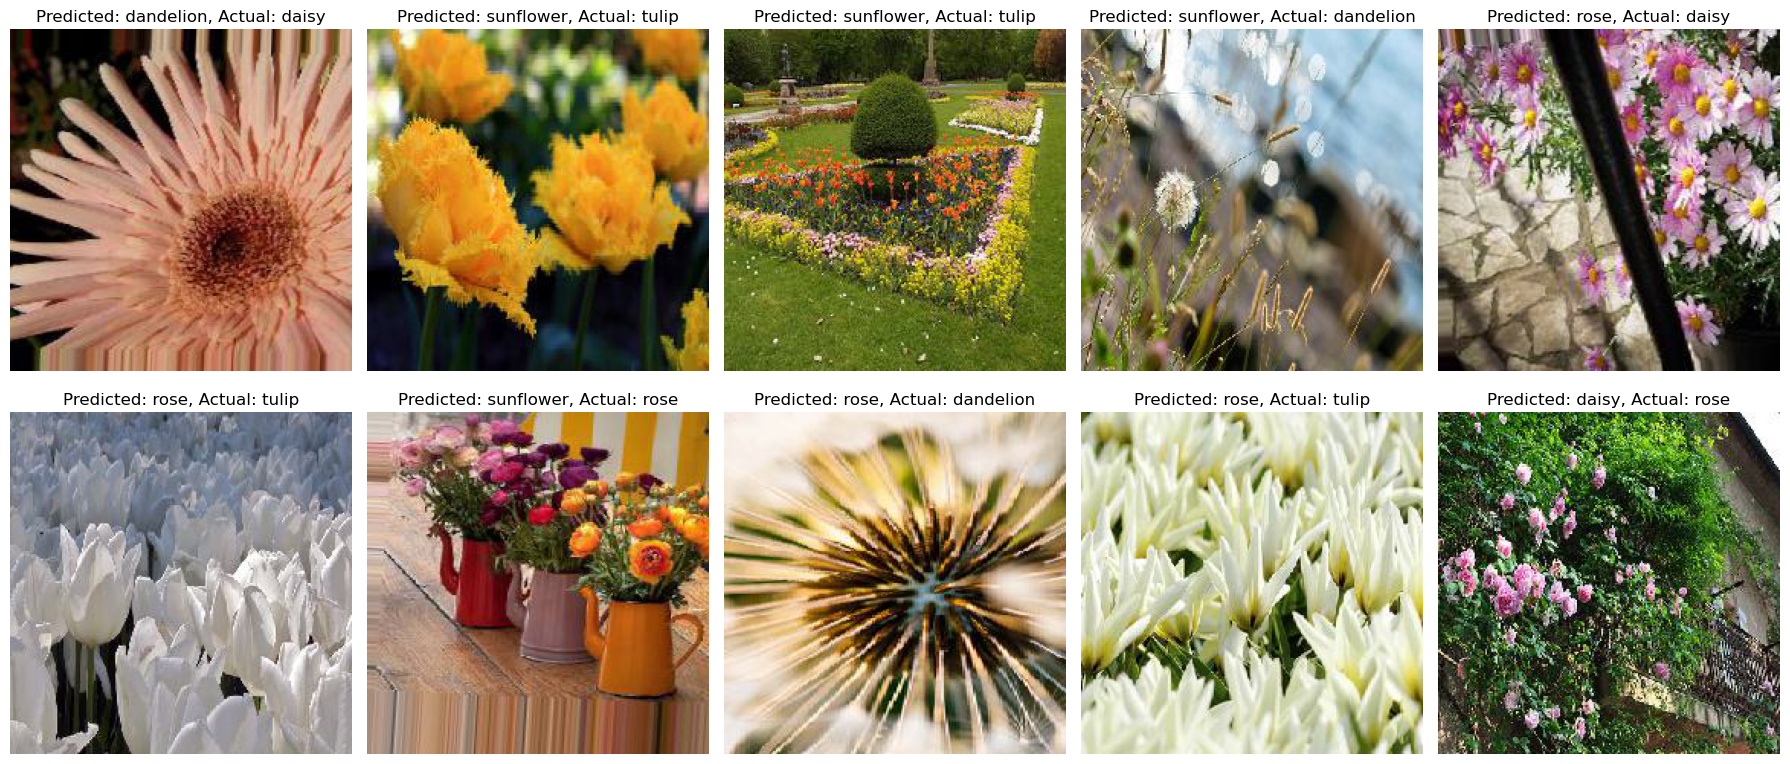

In [30]:
incorrect_indices = np.nonzero(predicted_classes != true_classes)[0]

incorrect_confidences = predictions[incorrect_indices, predicted_classes[incorrect_indices]]
lowest_confidence_indices = incorrect_indices[np.argsort(incorrect_confidences)[:10]]

print("These are the images that the model struggles to classify: ")

plt.figure(figsize=(18, 8))
for i, incorrect in enumerate(lowest_confidence_indices):
    plt.subplot(2, 5, i + 1)
    img = val_generator[incorrect // val_generator.batch_size][0][incorrect % val_generator.batch_size]
    plt.imshow(img)
    plt.title(f"Predicted: {class_labels[predicted_classes[incorrect]]}, Actual: {class_labels[true_classes[incorrect]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

### **What is the rough model complexity?**

Model complexity refers to the number of parameters or the architecture depth and breadth in a neural network. A model with more parameters is generally considered more complex and has a higher capacity to fit a wide range of functions. However, it's also more prone to overfitting if not trained with enough data or without proper regularization.

The parameters of this CNN model are:

In [31]:
print("This model has total a rough complexity of ~134 million parameters, making it a quite complex model.\n")

model.summary()

This model has total a rough complexity of ~134 million parameters, making it a quite complex model.

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 conv2d_27 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 112, 112, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 conv2d_29 (Conv2D)          (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_11 

### **Is the model's large size contributing to any challenges or constraints in its performance on the given dataset?**

There are few challenges and constraints that I faced in training this flower dataset with given CNN architecture.

**Vanishing Gradient Problem:**
 - At the beginning of training this model, I faced a serious vanishing gradient problem. The gradients could not backpropagate effectively, making the model untrainable. Deep networks, especially those without skip connections or normalization layers, are prone to this problem. As gradients are backpropagated through layers, they can become very small, essentially "vanishing," making it hard to train the deeper layers of the network. This issue can still occur with ReLU, especially in very deep architectures like yours, despite ReLU being designed to mitigate this problem to some extent. Later, the model can finally be trained when I used He Initialization and SELU Activation.

**Overfitting:**
 - A model with a large number of parameters has higher capacity and can easily memorize the training data, especially if the dataset is not large enough. This results in poor generalization to new, unseen data. For instance, this flower dataset has 4317 samples which is not large enough to train this kind of deep complex model. We can use transfer learning to improve the performance.

**Training Time:**
 - A larger model requires more computation, leading to longer training times. This can be a constraint if I am iterating over different models or hyperparameters.

## **Test the model by giving it a picture taken by your own phone camera.**


### **How can the accuracy of the model on the picture taken by your own phone camera be evaluated?**
- Load the photo.
- Preprocess the image to make it suitable for the model.
- Load the baseline model.
- Make a prediction.

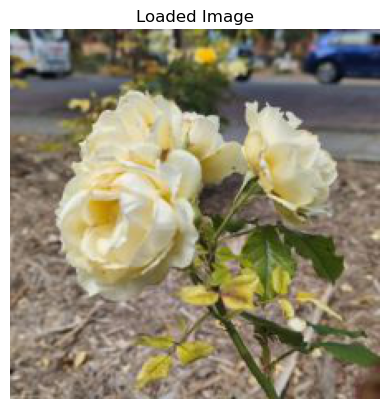

1/1 [==============================] - 0s 51ms/step
The image is most likely a rose with a probability of 0.56.
The true label is rose.


In [32]:
#Step 5 implementation
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

img_path = 'photo_rose.jpg'
img = image.load_img(img_path, target_size=(224, 224))

plt.imshow(img)
plt.title("Loaded Image")
plt.axis('off')
plt.show()

img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

model = load_model('best_model_baseline.h5')

predictions = model.predict(img_array)
predicted_class = np.argmax(predictions[0])

class_labels = list(val_generator.class_indices.keys())

print(f"The image is most likely a {class_labels[predicted_class]} with a probability of {predictions[0][predicted_class]:.2f}.")
print("The true label is rose.")

### **What can be done if the model does not perform well on the picture taken by your own phone camera?**

We can consider few points if the model does not perform well on the picture taken by own phone camera:


- Image Quality: Check if the image quality, lighting, or focus is drastically different from the images in your dataset. The model will likely perform better on high-quality images that resemble the training data.


- Augmentation and Diversity: Ensure that the training dataset has a diverse set of images. If possible, augment the training set with images taken under conditions similar to my phone camera.


- Transfer Learning: Consider using a pre-trained model and fine-tuning it on the dataset. These models are trained on millions of images and might generalize better to new images.


- Data Collection: Collect more real-world samples, like the ones from my phone camera, and include them in the training or fine-tuning process.

## **Use the same architecture but now train two different models one with L1 or L2 regularization, and one with batch normalization.**

### **Build L2 regularization model**

In [33]:
#Step 6 implementation
# build a L2 regularized model

from tensorflow.keras.regularizers import l2

l2_lambda = 0.01

model_l2 = Sequential()

model_l2.add(Conv2D(64, (3, 3), activation='selu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_lambda), input_shape=(224, 224, 3)))
model_l2.add(Conv2D(64, (3, 3), activation='selu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_lambda)))
model_l2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model_l2.add(Conv2D(128, (3, 3), activation='selu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_lambda)))
model_l2.add(Conv2D(128, (3, 3), activation='selu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_lambda)))
model_l2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model_l2.add(Conv2D(256, (3, 3), activation='selu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_lambda)))
model_l2.add(Conv2D(256, (3, 3), activation='selu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_lambda)))
model_l2.add(Conv2D(256, (3, 3), activation='selu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_lambda)))
model_l2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model_l2.add(Conv2D(512, (3, 3), activation='selu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_lambda)))
model_l2.add(Conv2D(512, (3, 3), activation='selu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_lambda)))
model_l2.add(Conv2D(512, (3, 3), activation='selu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_lambda)))
model_l2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model_l2.add(Conv2D(512, (3, 3), activation='selu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_lambda)))
model_l2.add(Conv2D(512, (3, 3), activation='selu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_lambda)))
model_l2.add(Conv2D(512, (3, 3), activation='selu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_lambda)))
model_l2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model_l2.add(Flatten())
model_l2.add(Dense(4096, activation='selu', kernel_initializer='he_normal', kernel_regularizer=l2(l2_lambda)))
model_l2.add(Dense(4096, activation='selu', kernel_initializer='he_normal', kernel_regularizer=l2(l2_lambda)))
model_l2.add(Dense(5, activation='softmax'))

model_l2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_39 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 conv2d_40 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 112, 112, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_41 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 conv2d_42 (Conv2D)          (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 56, 56, 128)      0         
 g2D)                                                 

In [34]:
from tensorflow.keras.callbacks import ModelCheckpoint
import time

checkpoint_filepath = 'best_model_l2.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


model_l2.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

start_time = time.time()

history_l2 = model_l2.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    callbacks=[model_checkpoint_callback])

end_time = time.time()
print(f"Total training time of L2 model: {end_time - start_time} seconds")

model_l2.save('model_l2.h5')

Epoch 1/25
229/229 [==============================] - 29s 123ms/step - loss: 248.6105 - accuracy: 0.4188 - val_loss: 232.2815 - val_accuracy: 0.6263
Epoch 2/25
229/229 [==============================] - 27s 119ms/step - loss: 222.2223 - accuracy: 0.5516 - val_loss: 211.1742 - val_accuracy: 0.5900
Epoch 3/25
229/229 [==============================] - 28s 124ms/step - loss: 200.6019 - accuracy: 0.5986 - val_loss: 189.8678 - val_accuracy: 0.6550
Epoch 4/25
229/229 [==============================] - 29s 124ms/step - loss: 179.6186 - accuracy: 0.6363 - val_loss: 169.5397 - val_accuracy: 0.6787
Epoch 5/25
229/229 [==============================] - 28s 120ms/step - loss: 160.1860 - accuracy: 0.6534 - val_loss: 150.9086 - val_accuracy: 0.6538
Epoch 6/25
229/229 [==============================] - 28s 124ms/step - loss: 142.3699 - accuracy: 0.6701 - val_loss: 133.9420 - val_accuracy: 0.7200
Epoch 7/25
229/229 [==============================] - 29s 125ms/step - loss: 126.2356 - accuracy: 0.6906 -

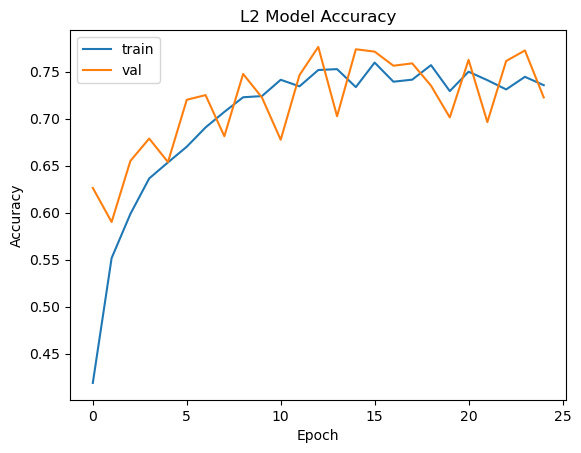

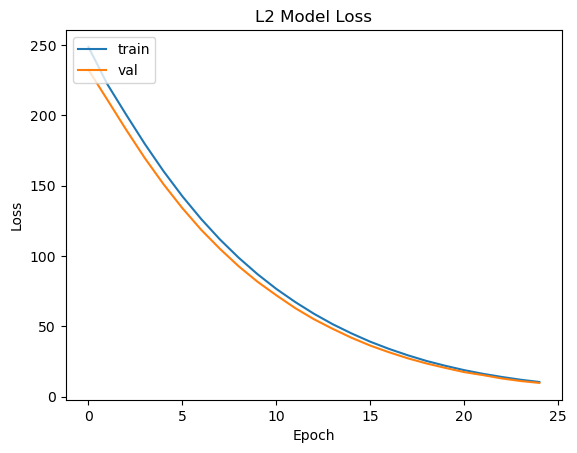

In [35]:
# plot the training and validation accuracy and loss at each epoch
import matplotlib.pyplot as plt

plt.plot(history_l2.history['accuracy'])
plt.plot(history_l2.history['val_accuracy'])
plt.title('L2 Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history_l2.history['loss'])
plt.plot(history_l2.history['val_loss'])
plt.title('L2 Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### **Build batch normalization model**

In [36]:
# build a batch normalization model
from tensorflow.keras.layers import BatchNormalization

model_bn = Sequential()

model_bn.add(Conv2D(64, (3, 3), activation='selu', padding='same', kernel_initializer='he_normal', input_shape=(224, 224, 3)))
model_bn.add(Conv2D(64, (3, 3), activation='selu', padding='same', kernel_initializer='he_normal'))
model_bn.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model_bn.add(BatchNormalization())

model_bn.add(Conv2D(128, (3, 3), activation='selu', padding='same', kernel_initializer='he_normal'))
model_bn.add(Conv2D(128, (3, 3), activation='selu', padding='same', kernel_initializer='he_normal'))
model_bn.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model_bn.add(BatchNormalization())

model_bn.add(Conv2D(256, (3, 3), activation='selu', padding='same', kernel_initializer='he_normal'))
model_bn.add(Conv2D(256, (3, 3), activation='selu', padding='same', kernel_initializer='he_normal'))
model_bn.add(Conv2D(256, (3, 3), activation='selu', padding='same', kernel_initializer='he_normal'))
model_bn.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model_bn.add(BatchNormalization())

model_bn.add(Conv2D(512, (3, 3), activation='selu', padding='same', kernel_initializer='he_normal'))
model_bn.add(Conv2D(512, (3, 3), activation='selu', padding='same', kernel_initializer='he_normal'))
model_bn.add(Conv2D(512, (3, 3), activation='selu', padding='same', kernel_initializer='he_normal'))
model_bn.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model_bn.add(BatchNormalization())

model_bn.add(Conv2D(512, (3, 3), activation='selu', padding='same', kernel_initializer='he_normal'))
model_bn.add(Conv2D(512, (3, 3), activation='selu', padding='same', kernel_initializer='he_normal'))
model_bn.add(Conv2D(512, (3, 3), activation='selu', padding='same', kernel_initializer='he_normal'))
model_bn.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model_bn.add(BatchNormalization())

model_bn.add(Flatten())
model_bn.add(Dense(4096, activation='selu', kernel_initializer='he_normal'))
model_bn.add(Dense(4096, activation='selu', kernel_initializer='he_normal'))
model_bn.add(Dense(5, activation='softmax'))

model_bn.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_52 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 conv2d_53 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 112, 112, 64)     0         
 g2D)                                                            
                                                                 
 batch_normalization (BatchN  (None, 112, 112, 64)     256       
 ormalization)                                                   
                                                                 
 conv2d_54 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 conv2d_55 (Conv2D)          (None, 112, 112, 128)    

In [37]:
from tensorflow.keras.callbacks import ModelCheckpoint
import time

checkpoint_filepath = 'best_model_bn.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


model_bn.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

start_time = time.time()

history_bn = model_bn.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    callbacks=[model_checkpoint_callback])

end_time = time.time()
print(f"Total training time of batch normalization model: {end_time - start_time} seconds")

model_bn.save('model_bn.h5')

Epoch 1/25
229/229 [==============================] - 29s 123ms/step - loss: 4.9310 - accuracy: 0.4869 - val_loss: 4.8427 - val_accuracy: 0.6175
Epoch 2/25
229/229 [==============================] - 28s 121ms/step - loss: 2.6100 - accuracy: 0.5672 - val_loss: 1.9028 - val_accuracy: 0.5888
Epoch 3/25
229/229 [==============================] - 29s 126ms/step - loss: 1.3586 - accuracy: 0.6520 - val_loss: 0.7406 - val_accuracy: 0.7550
Epoch 4/25
229/229 [==============================] - 28s 120ms/step - loss: 0.8331 - accuracy: 0.7261 - val_loss: 0.6934 - val_accuracy: 0.7475
Epoch 5/25
229/229 [==============================] - 28s 122ms/step - loss: 0.6673 - accuracy: 0.7666 - val_loss: 0.9245 - val_accuracy: 0.7212
Epoch 6/25
229/229 [==============================] - 29s 126ms/step - loss: 0.6006 - accuracy: 0.7951 - val_loss: 0.7652 - val_accuracy: 0.7575
Epoch 7/25
229/229 [==============================] - 28s 121ms/step - loss: 0.5387 - accuracy: 0.8133 - val_loss: 0.8119 - val_ac

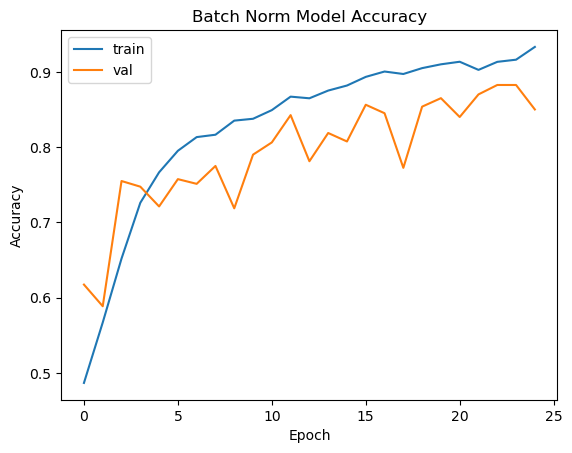

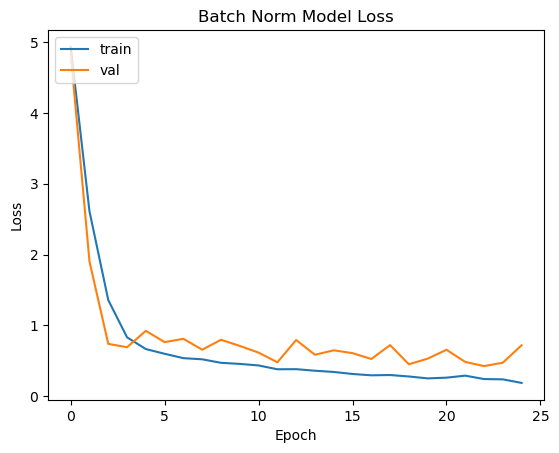

In [38]:
# plot the training and validation accuracy and loss at each epoch
import matplotlib.pyplot as plt

plt.plot(history_bn.history['accuracy'])
plt.plot(history_bn.history['val_accuracy'])
plt.title('Batch Norm Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history_bn.history['loss'])
plt.plot(history_bn.history['val_loss'])
plt.title('Batch Norm Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### **Based on the results of the regularized and batch normalized models, how effective are L1 or L2 regularization and batch normalization techniques? How do they impact the model's performance, convergence, size, and inference time?**

#### **Compare L2 regularization model to baseline model:**
**Performance:**
- Based on the results above, the best training and validation accuracy of L2 regularized model are around 0.76 and 0.77, which is worse than the baseline model (which are around 0.88 and 0.83). 

**Convergence:**
- Based on the accuracy and loss graph shown above, there is faster loss drop in baseline model. Without any regularization, the model is free to adjust its weights to minimize the loss as quickly as possible. This often leads to a steeper decrease in training loss.

- In opposite, there is slower and smoother loss drop in L2 regularized model. L2 regularization penalizes large weights, effectively adding a cost to the loss function. This means the model has to balance between fitting the data and keeping the weights small.

- The rate of convergence does not necessarily equate to the quality of convergence. Convergence should be gauged not just by the training loss but also by the validation loss. The L2 regularized model's slower and smoother descent is indicative of a more robust convergence process. It is finding a balance between fitting the data and not overfitting, leading to potentially better generalization on unseen data.

**Size:**
- L2 regularization does not directly reduce the number of parameters. Therefore, there is no impact on the model size.

**Inference time:**
- L2 regularization does not directly impact inference time.

#### **Compare Batch Normalization model to baseline model:**
**Performance:**
- Based on the results above, the best training and validation accuracy of model with batch normalization are around 0.93 and 0.88, which is better than the baseline model (which are around 0.88 and 0.83). This aligns with the expectation. Typically, adding batch normalization improves the model's performance. By normalizing the activations of each layer, it allows each layer to learn on a more stable distribution of inputs. This can lead to better generalization and less overfitting. Moreover, it can help the problem of vanishing gradient.

**Convergence:**
- Based on the accuracy and loss graph shown above, batch normalization can lead to faster convergence. By changing in the distribution of layer inputs during training, it allows for higher learning rates and reduces the sensitivity to the initial weight initialization. This can result in fewer epochs needed to reach a comparable performance.

- Without batch normalization, the model might require careful weight initialization and smaller learning rates to converge, especially for deeper networks. Training might also take longer.

**Size:**
- The model size increases slightly with batch normalization since it introduces additional parameters (gamma and beta for scaling and shifting) for each feature in the layers where it is applied. Additionally, it keeps track of the running mean and variance for each feature, which are used during inference.

**Inference time:**
- The inference time might be slightly longer with batch normalization since the model has to apply the normalization using the stored running mean and variance for each batch-normalized layer. However, in many practical scenarios, this increase is minimal and often overshadowed by the benefits batch normalization brings to model training and performance.

### **How do the learned weights of the L1 or L2 regularized models compare to the baseline model? Provide any insights on the differences in the learned weights and what it implies for the model's performance and interpretability?**

**Magnitude of Weights:**

L2 regularization penalizes large weights, so the learned weights in L2 regularized models tend to be smaller in magnitude compared to those in non-regularized models. This is because L2 regularization adds a term to the loss function that is proportional to the sum of the squared weights, making it costly for the model to have large weights.

**Performance and Overfitting:**

The constraint on the magnitude of the weights can lead to better generalization. By preventing weights from becoming too large, L2 regularization can help the model avoid fitting noise and outliers in the training data, reducing the risk of overfitting.

**Interpretability:**

Smaller weights can make the model more stable and potentially easier to interpret. When weights are bounded and do not take on extreme values, it is less likely that small changes in input will result in drastic changes in output.

#### **Compare the magnitude of the weights between L2 regularized model and baseline model.**

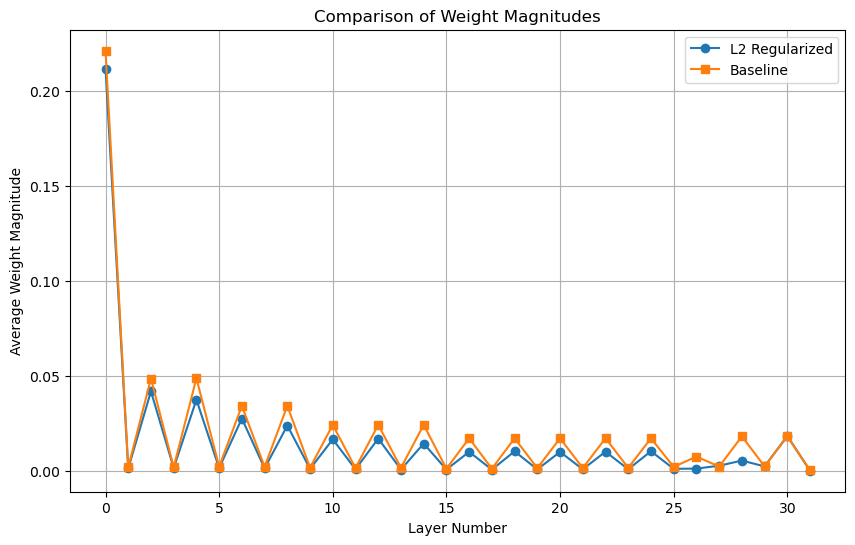

In [39]:
import tensorflow as tf

l2_model = tf.keras.models.load_model('best_model_l2.h5')
baseline_model = tf.keras.models.load_model('best_model_baseline.h5')

l2_weights = l2_model.get_weights()
baseline_weights = baseline_model.get_weights()

l2_magnitudes = [tf.reduce_mean(tf.abs(w)).numpy() for w in l2_weights]
baseline_magnitudes = [tf.reduce_mean(tf.abs(w)).numpy() for w in baseline_weights]

plt.figure(figsize=(10, 6))
plt.plot(l2_magnitudes, 'o-', label='L2 Regularized')
plt.plot(baseline_magnitudes, 's-', label='Baseline')
plt.xlabel('Layer Number')
plt.ylabel('Average Weight Magnitude')
plt.title('Comparison of Weight Magnitudes')
plt.legend()
plt.grid(True)
plt.show()

### **What insights can be drawn from the comprehensive analysis of the regularized and batch normalized models regarding the use of regularization and normalization techniques in training machine learning models?**

**Regularization (e.g., L2 Regularization) Insights:**

* Prevents Overfitting: Regularization techniques, like L2 regularization, add a penalty to the loss function based on the magnitude of the model parameters. This discourages the model from assigning too much importance to any single feature and helps prevent overfitting, especially in models with a large number of parameters.

* Weight Magnitude: Regularized models often have smaller weight magnitudes compared to non-regularized models. This can lead to more stable and interpretable models.

* Generalization: Regularized models often generalize better to unseen data as they are less prone to fitting noise and outliers in the training data.

* Performance: In my case, using L2 regularization leads to weaker performance in terms of accuracy compared to a non-regularized model. It may be caused by the lambda which controls the strength of the regularization is too high. It causes the model to become too simple and underfit the data. This means the model may not capture the underlying patterns in the training data effectively.

**Batch Normalization Insights:**

* Improves Convergence: Batch normalization can speed up convergence by addressing the internal covariate shift, making optimization landscapes smoother, and allowing the use of higher learning rates.

* Mitigates Vanishing/Exploding Gradient: By normalizing the activations, batch normalization can help mitigate issues like vanishing or exploding gradients, especially in deep networks. Initially, the given network architecture cannot be trained properly due to the problem of vanishing gradient. Batch normalization can help with this case.

* Performance Boost: Batch normalization can lead to performance improvements by ensuring each layer has a consistent and normalized input distribution. This can make the training process more stable and less sensitive to weight initialization. It improves the validation accuracy from 0.83 to 0.92 just by adding batch normalzation layers.

* Inference Overhead: While batch normalization provides several benefits during training, it introduces additional computations during inference. This can slightly increase the inference time.

**Combined Insights:**

* Synergy: Using both regularization and normalization can offer synergistic benefits. For instance, batch normalization can help in faster convergence, while regularization can help in achieving better generalization.

* Model Robustness: Combining these techniques can lead to more robust models that perform well across various datasets and are less sensitive to hyperparameter settings.

* Trade-offs: It is essential to understand the trade-offs. For instance, while batch normalization can speed up training, it might introduce slight overhead during inference.

## **Improve the accuracy by trying something extra.** 

### **By incorporating additional training strategies such as regularization techniques like dropout, data augmentation, and batch or layer normalization, can the accuracy of the model be improved?**

#### **Build models with dropout, L2 regularization and batch normalization**

In [40]:
#Step 7 implementation
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import he_normal

lambda_value = 0.001

model_l2_bn = Sequential([
    # First block
    Conv2D(64, (3, 3), padding='same', activation='selu', kernel_regularizer=l2(lambda_value), kernel_initializer=he_normal(), input_shape=(224, 224, 3)),
    Conv2D(64, (3, 3), padding='same', activation='selu', kernel_regularizer=l2(lambda_value), kernel_initializer=he_normal()),    
    MaxPooling2D(2, 2),
    BatchNormalization(),
    Dropout(0.2),

    Conv2D(128, (3, 3), padding='same', activation='selu', kernel_regularizer=l2(lambda_value), kernel_initializer=he_normal()),
    Conv2D(128, (3, 3), padding='same', activation='selu', kernel_regularizer=l2(lambda_value), kernel_initializer=he_normal()),    
    MaxPooling2D(2, 2),
    BatchNormalization(),    

    Conv2D(256, (3, 3), padding='same', activation='selu', kernel_regularizer=l2(lambda_value), kernel_initializer=he_normal()),
    Conv2D(256, (3, 3), padding='same', activation='selu', kernel_regularizer=l2(lambda_value), kernel_initializer=he_normal()),
    Conv2D(256, (3, 3), padding='same', activation='selu', kernel_regularizer=l2(lambda_value), kernel_initializer=he_normal()),    
    MaxPooling2D(2, 2),
    BatchNormalization(),
    Dropout(0.2),

    Conv2D(512, (3, 3), padding='same', activation='selu', kernel_regularizer=l2(lambda_value), kernel_initializer=he_normal()),
    Conv2D(512, (3, 3), padding='same', activation='selu', kernel_regularizer=l2(lambda_value), kernel_initializer=he_normal()),
    Conv2D(512, (3, 3), padding='same', activation='selu', kernel_regularizer=l2(lambda_value), kernel_initializer=he_normal()),
    MaxPooling2D(2, 2),
    BatchNormalization(),    

    Conv2D(512, (3, 3), padding='same', activation='selu', kernel_regularizer=l2(lambda_value), kernel_initializer=he_normal()),
    Conv2D(512, (3, 3), padding='same', activation='selu', kernel_regularizer=l2(lambda_value), kernel_initializer=he_normal()),
    Conv2D(512, (3, 3), padding='same', activation='selu', kernel_regularizer=l2(lambda_value), kernel_initializer=he_normal()),
    MaxPooling2D(2, 2),
    BatchNormalization(),
    Dropout(0.2),

    Flatten(),
    Dense(4096, activation='selu', kernel_regularizer=l2(lambda_value), kernel_initializer=he_normal()),
    Dense(4096, activation='selu', kernel_regularizer=l2(lambda_value), kernel_initializer=he_normal()),
    Dense(5, activation='softmax')
])

model_l2_bn.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_65 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 conv2d_66 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 112, 112, 64)     0         
 g2D)                                                            
                                                                 
 batch_normalization_5 (Batc  (None, 112, 112, 64)     256       
 hNormalization)                                                 
                                                                 
 dropout (Dropout)           (None, 112, 112, 64)      0         
                                                                 
 conv2d_67 (Conv2D)          (None, 112, 112, 128)    

In [41]:
from tensorflow.keras.callbacks import ModelCheckpoint
import time

checkpoint_filepath = 'best_model_l2_bn.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


model_l2_bn.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

start_time = time.time()

e = 100
bs = 32

history_l2_bn = model_l2_bn.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // bs,
    epochs=e,
    validation_data=val_generator,
    validation_steps=val_generator.samples // bs,
    callbacks=[model_checkpoint_callback])

end_time = time.time()
print(f"Total training time of L2, batch normalization and dropout model: {end_time - start_time} seconds")

model_l2_bn.save('model_l2_bn.h5')

Epoch 1/100
229/229 [==============================] - 29s 122ms/step - loss: 29.6188 - accuracy: 0.4787 - val_loss: 28.9965 - val_accuracy: 0.4250
Epoch 2/100
229/229 [==============================] - 28s 123ms/step - loss: 27.2230 - accuracy: 0.5356 - val_loss: 26.1975 - val_accuracy: 0.5500
Epoch 3/100
229/229 [==============================] - 28s 123ms/step - loss: 25.2953 - accuracy: 0.6298 - val_loss: 25.0536 - val_accuracy: 0.5813
Epoch 4/100
229/229 [==============================] - 27s 117ms/step - loss: 24.1966 - accuracy: 0.6989 - val_loss: 24.5680 - val_accuracy: 0.5562
Epoch 5/100
229/229 [==============================] - 27s 118ms/step - loss: 23.2650 - accuracy: 0.7412 - val_loss: 23.5514 - val_accuracy: 0.5462
Epoch 6/100
229/229 [==============================] - 28s 123ms/step - loss: 22.4040 - accuracy: 0.7582 - val_loss: 22.0381 - val_accuracy: 0.7325
Epoch 7/100
229/229 [==============================] - 27s 119ms/step - loss: 21.4551 - accuracy: 0.7787 - val_l

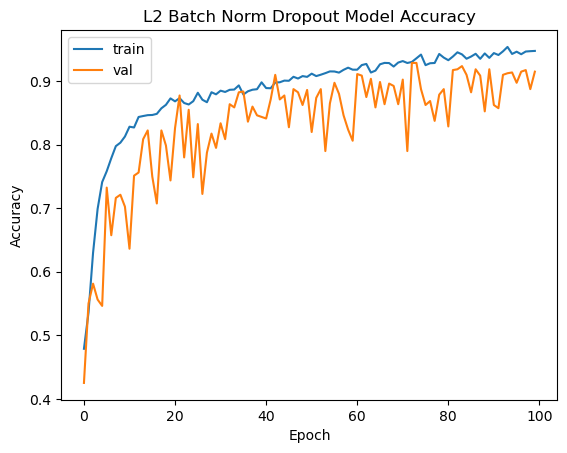

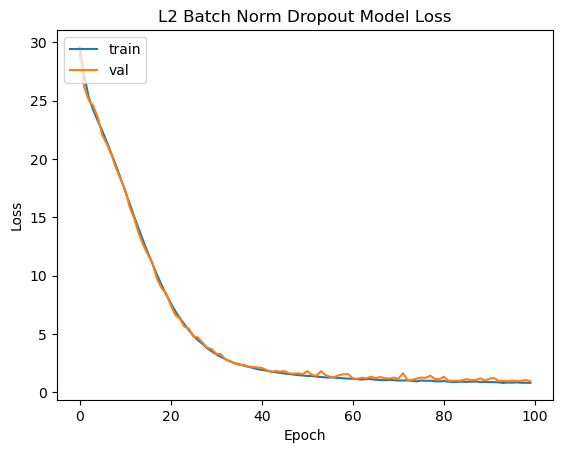

In [42]:
# plot the training and validation accuracy and loss at each epoch
import matplotlib.pyplot as plt

plt.plot(history_l2_bn.history['accuracy'])
plt.plot(history_l2_bn.history['val_accuracy'])
plt.title('L2 Batch Norm Dropout Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history_l2_bn.history['loss'])
plt.plot(history_l2_bn.history['val_loss'])
plt.title('L2 Batch Norm Dropout Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### **Result of using L2 regularization, batch normalization and dropout:**

* The model with L2 regularization, batch normalization and dropout outperform baseline model with best training accuracy around 0.95 and validation accuracy around 0.93 (baseline model is 0.88 and 0.83.)
* The model perform slightly better than the model with only using batch normalization (batch normalization only model is around 0.93 and 0.88). There is slight improvement adding regularization and dropout. Moreover, the training and validation loss converge smoother with regularization than the model with batch normalization only.


### **Modify the given model architecture to improve the accuracy over the baseline**

#### **Try to modify the model architecture to ResNet50**

In [43]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Add, Activation, Flatten, Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, ZeroPadding2D
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import he_normal

def identity_block(X, f, filters):
    F1, F2, F3 = filters
    
    X_shortcut = X
    
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_initializer=he_normal())(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', kernel_initializer=he_normal())(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_initializer=he_normal())(X)
    X = BatchNormalization(axis=3)(X)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

def convolutional_block(X, f, filters, s=2):
    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(F1, (1, 1), strides=(s, s), kernel_initializer=he_normal())(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    X = Conv2D(F2, (f, f), strides=(1, 1), padding='same', kernel_initializer=he_normal())(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    X = Conv2D(F3, (1, 1), strides=(1, 1), padding='valid', kernel_initializer=he_normal())(X)
    X = BatchNormalization(axis=3)(X)

    X_shortcut = Conv2D(F3, (1, 1), strides=(s, s), padding='valid', kernel_initializer=he_normal())(X_shortcut)
    X_shortcut = BatchNormalization(axis=3)(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

input_shape = (224, 224, 3)
input_img = Input(shape=input_shape)

X = ZeroPadding2D((3, 3))(input_img)
X = Conv2D(64, (7, 7), strides=(2, 2), kernel_initializer=he_normal())(X)
X = BatchNormalization(axis=3)(X)
X = Activation('relu')(X)
X = MaxPooling2D((3, 3), strides=(2, 2))(X)

X = convolutional_block(X, f=3, filters=[64, 64, 256], s=1)
X = identity_block(X, 3, [64, 64, 256])
X = identity_block(X, 3, [64, 64, 256])

X = convolutional_block(X, f=3, filters=[128, 128, 512])
X = identity_block(X, 3, [128, 128, 512])
X = identity_block(X, 3, [128, 128, 512])
X = identity_block(X, 3, [128, 128, 512])

X = convolutional_block(X, f=3, filters=[256, 256, 1024])
X = identity_block(X, 3, [256, 256, 1024])
X = identity_block(X, 3, [256, 256, 1024])
X = identity_block(X, 3, [256, 256, 1024])
X = identity_block(X, 3, [256, 256, 1024])
X = identity_block(X, 3, [256, 256, 1024])

X = convolutional_block(X, f=3, filters=[512, 512, 2048])
X = identity_block(X, 3, [512, 512, 2048])
X = identity_block(X, 3, [512, 512, 2048])

X = GlobalAveragePooling2D()(X)
X = Dense(5, activation='softmax', kernel_initializer=he_normal())(X)

model_res = Model(inputs=input_img, outputs=X)

model_res.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv2d_78 (Conv2D)             (None, 112, 112, 64  9472        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

In [44]:
from tensorflow.keras.callbacks import ModelCheckpoint
import time

checkpoint_filepath = 'best_model_res.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


model_res.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

start_time = time.time()

e = 100
bs = 32

history_res = model_res.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // bs,
    epochs=e,
    validation_data=val_generator,
    validation_steps=val_generator.samples // bs,
    callbacks=[model_checkpoint_callback])

end_time = time.time()
print(f"Total training time of Residual Net model: {end_time - start_time} seconds")

model_res.save('model_res.h5')

Epoch 1/100
229/229 [==============================] - 29s 120ms/step - loss: 1.2659 - accuracy: 0.4945 - val_loss: 1.6324 - val_accuracy: 0.3812
Epoch 2/100
229/229 [==============================] - 27s 118ms/step - loss: 1.0459 - accuracy: 0.5986 - val_loss: 1.8141 - val_accuracy: 0.5537
Epoch 3/100
229/229 [==============================] - 27s 119ms/step - loss: 0.9910 - accuracy: 0.6140 - val_loss: 1.3460 - val_accuracy: 0.5638
Epoch 4/100
229/229 [==============================] - 27s 118ms/step - loss: 0.9219 - accuracy: 0.6486 - val_loss: 1.1355 - val_accuracy: 0.6550
Epoch 5/100
229/229 [==============================] - 27s 118ms/step - loss: 0.8727 - accuracy: 0.6708 - val_loss: 1.0372 - val_accuracy: 0.6775
Epoch 6/100
229/229 [==============================] - 27s 116ms/step - loss: 0.8203 - accuracy: 0.6906 - val_loss: 1.0412 - val_accuracy: 0.6413
Epoch 7/100
229/229 [==============================] - 27s 116ms/step - loss: 0.7852 - accuracy: 0.7070 - val_loss: 1.4019 -

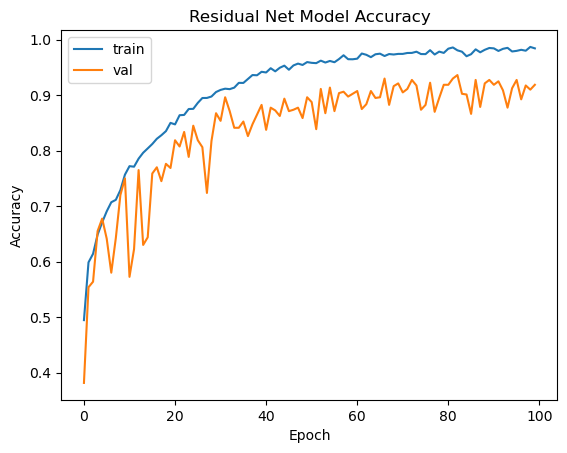

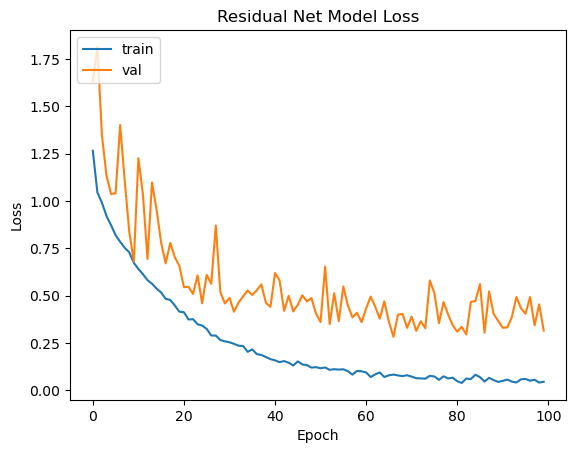

In [45]:
# plot the training and validation accuracy and loss at each epoch
import matplotlib.pyplot as plt

plt.plot(history_res.history['accuracy'])
plt.plot(history_res.history['val_accuracy'])
plt.title('Residual Net Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history_res.history['loss'])
plt.plot(history_res.history['val_loss'])
plt.title('Residual Net Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### **Result of modification of model**

* The model is modified by adding residual connection and like ResNet. It outperform baseline model with best training accuracy around 0.98 and validation accuracy around 0.93 (baseline model is 0.88 and 0.83.)

* The model perform similiar to the model with L2 regularization, batch normalization and dropout (L2, batch normalization and dropout model is around 0.95 and 0.92). There is not much improvement adding residual connection.

### **Use transfer learning to fine-tune an existing pre-trained model to improve accuracy**

I would choose feature extraction approach. The choice between feature extraction and fine-tuning depends on the size and similarity of our dataset relative to the dataset the model was pre-trained on. Given the flower dataset, it is not too large and is somewhat similar to general ImageNet classes (which includes various plants and flowers), starting with feature extraction would be a good approach.

In [46]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

model_transfer = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax'),
])

In [47]:
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import time

checkpoint_filepath = 'best_model_transfer.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


for layer in base_model.layers[-20:]:
    layer.trainable = True

model_transfer.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

start_time = time.time()

e = 25
bs = 32

history_transfer = model_transfer.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // bs,
    epochs=e,
    validation_data=val_generator,
    validation_steps=val_generator.samples // bs,
    callbacks=[model_checkpoint_callback])

end_time = time.time()
print(f"Total training time of transfer learning model: {end_time - start_time} seconds")

model_transfer.save('model_transfer.h5')

Epoch 1/25
229/229 [==============================] - 28s 119ms/step - loss: 0.5518 - accuracy: 0.8136 - val_loss: 0.2537 - val_accuracy: 0.9137
Epoch 2/25
229/229 [==============================] - 27s 118ms/step - loss: 0.2998 - accuracy: 0.8965 - val_loss: 0.2157 - val_accuracy: 0.9275
Epoch 3/25
229/229 [==============================] - 27s 116ms/step - loss: 0.2510 - accuracy: 0.9151 - val_loss: 0.2053 - val_accuracy: 0.9350
Epoch 4/25
229/229 [==============================] - 27s 119ms/step - loss: 0.2113 - accuracy: 0.9261 - val_loss: 0.2177 - val_accuracy: 0.9438
Epoch 5/25
229/229 [==============================] - 27s 118ms/step - loss: 0.1889 - accuracy: 0.9341 - val_loss: 0.1991 - val_accuracy: 0.9425
Epoch 6/25
229/229 [==============================] - 27s 118ms/step - loss: 0.1729 - accuracy: 0.9418 - val_loss: 0.2040 - val_accuracy: 0.9400
Epoch 7/25
229/229 [==============================] - 27s 118ms/step - loss: 0.1437 - accuracy: 0.9503 - val_loss: 0.2342 - val_ac

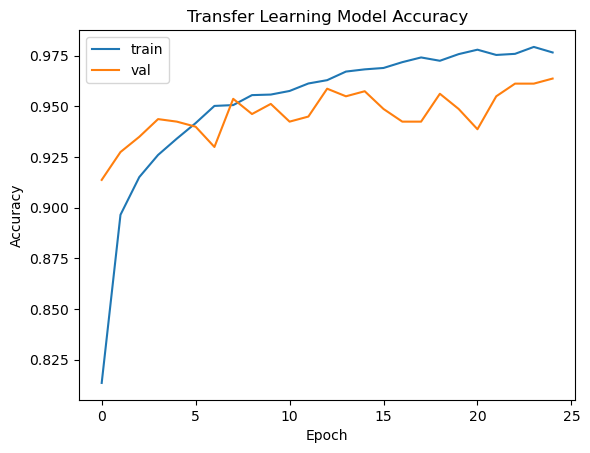

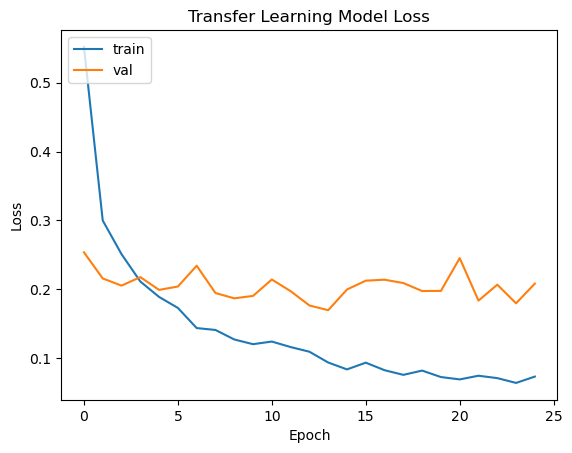

In [48]:
# plot the training and validation accuracy and loss at each epoch
import matplotlib.pyplot as plt

plt.plot(history_transfer.history['accuracy'])
plt.plot(history_transfer.history['val_accuracy'])
plt.title('Transfer Learning Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history_transfer.history['loss'])
plt.plot(history_transfer.history['val_loss'])
plt.title('Transfer Learning Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### **Result of using Transfer Learning Model**

* The model is using transfer learning model (base model is InceptionV3). It outperform all the models tested above including L2, batch normalization, skip connection, etc. with best training accuracy around 0.98 and validation accuracy around 0.96 (baseline model is 0.88 and 0.83.)

* The transfer learning approach, leveraging the pre-trained InceptionV3 model, has demonstrated superior performance on the flower dataset. With a remarkable accuracy over 0.96, it is evident that utilizing knowledge from pre-existing models trained on large datasets (like ImageNet) can significantly boost the performance on specific tasks, even when the target dataset is relatively smaller or different in nature.

* Transfer learning not only improves performance but also reduces the training time. Instead of learning all the intricate features from scratch, the model fine-tunes pre-learned features, leading to quicker convergence.